In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *

In [2]:
style.use('ggplot')

In [3]:
NRUNS = 1

## Get parameters from calibration

In [5]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [29]:
input_parameters = [0.15863974, 0.056454  , 0.20454462, 6.05054016, 2.22042767, 0.47684635, 0.9962696]

In [12]:
burn_in_period = 250

In [31]:
labels = ['std_noise', 'w_random', 'strat_share_chartists', 'base_risk_aversion', 
          "fundamentalist_horizon_multiplier", "mutation_intensity", "average_learning_ability"]

In [32]:
uncertain_parameters = dict(zip(labels, input_parameters))
params = {"ticks": 600 + burn_in_period, "fundamental_value": 166, 'n_traders': 500, 'std_fundamental': 0.0530163128919286,
          'spread_max': 0.004087, "init_stocks": 50, 'trader_sample_size': 19,
          'horizon': 200, "trades_per_tick": 4}
params.update(uncertain_parameters)
params

{'ticks': 850,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 4,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.20454462,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.47684635,
 'average_learning_ability': 0.9962696}

In [58]:
# params = {"fundamental_value": 166,
#               "trader_sample_size": 10, "n_traders": 1000,
#               "ticks": 500, "std_fundamental": 0.0530163128919286,
#               "std_noise": 0.10696588473846724, "w_random": 0.1,
#               "strat_share_chartists": 0.8,
#               "init_stocks": 50, "base_risk_aversion": 11.0,
#               'spread_max': 0.004087, "horizon": 200,
#               "fundamentalist_horizon_multiplier": 0.2,
#               "trades_per_tick": 4, "mutation_intensity": 0.05,
#               "average_learning_ability": 0.8}
params['strat_share_chartists'] = 0.0
params['average_learning_ability'] = 0.0

In [86]:
with open('parameters.json', 'w') as fp:
    json.dump(params, fp)

## Run model

In [59]:
params['ticks'] = 5000

In [60]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0


# Price dynamics

In [61]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=200)

In [62]:
y = pd.Series(mc_prices[0][:-1] / mc_fundamentals[0])

Text(0.5, 0, 'Simulation time')

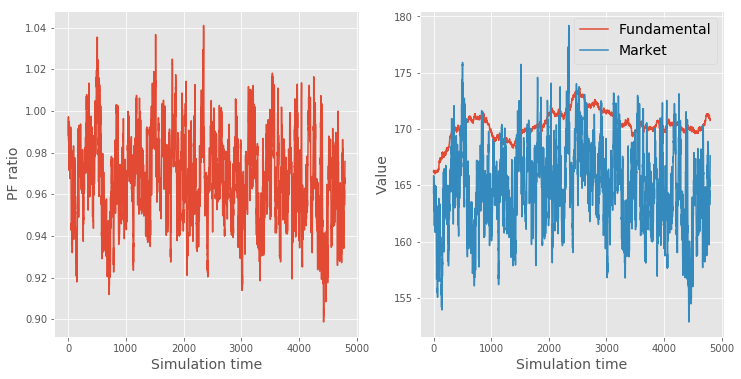

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

#ax1.plot(mc_returns.index, mc_returns[1], label='returns')
ax1.plot(y.index, y, label='pf ratio')

ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('PF ratio', fontsize='14')

ax2.plot(mc_fundamentals.index, mc_fundamentals[0], label='Fundamental')
ax2.plot(mc_prices.index, mc_prices[0], label='Market')

ax2.set_ylabel('Value', fontsize='14')
ax2.legend(loc='best', fontsize='14')
ax2.set_xlabel('Simulation time', fontsize='14')

#fig.savefig('prices_and_returns.png')

# Idendify bubbles

In [37]:
obs = len(y)
r0 = 0.01 + 1.8/np.sqrt(obs)
swindow0 = int(math.floor(r0*obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 99

In [38]:
bsadfs = PSY(y, swindow0, IC, adflag)
quantilesBsadf = cvPSYwmboot(y, swindow0, IC, adflag, Tb, nboot=99)

In [39]:
monitorDates = y.iloc[swindow0-1:obs].index
quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
ind95 =(bsadfs.T[0] > quantile95[1, ])
periods = monitorDates[ind95]

In [40]:
if True in ind95:
    bubbly_dates = find_sequences_ints(periods, monitorDates)
else:
    print('no bubbles')

Text(0, 0.5, 'Ratio')

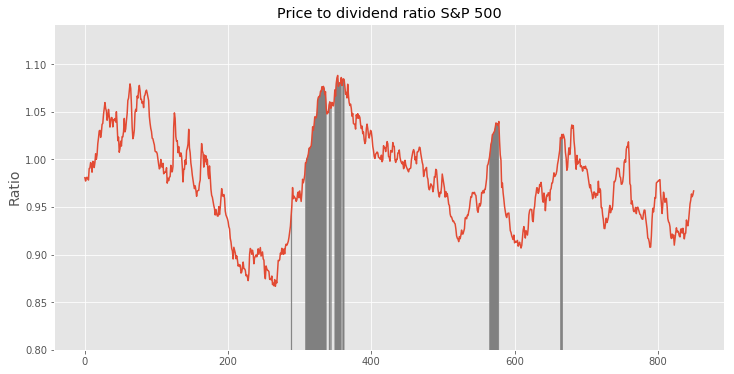

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,6))

ax1.plot(range(len(y)), y)

for loc in range(len(bubbly_dates)):
    bub_period = bubble_period(monitorDates , bubbly_dates.iloc[loc])
    ax1.fill_between(bub_period , y[bub_period], color='grey')

    
ax1.set_ylim(0.80, )

ax1.set_title('Price to dividend ratio S&P 500')
ax1.set_ylabel('Ratio', fontsize='14')

NameError: name 'proper_bubbles' is not defined

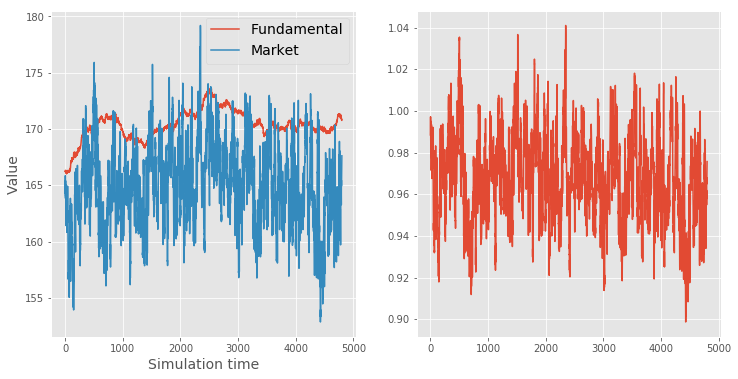

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))


ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('PF ratio', fontsize='14')

ax1.plot(mc_fundamentals.index, mc_fundamentals[0], label='Fundamental')
ax1.plot(mc_prices.index, mc_prices[0], label='Market')

ax1.set_ylabel('Value', fontsize='14')
ax1.legend(loc='best', fontsize='14')

ax2.plot(range(len(y)), y, label='pf ratio')

for loc in range(len(proper_bubbles)):
    bub_period = bubble_period(monitorDates , proper_bubbles.iloc[loc])
    ax2.fill_between(bub_period , y[bub_period], color='grey')
    
ax2.set_ylabel('PF ratio', fontsize='14')

ax2.set_ylim(0.85, 1.1)
ax2.set_xlabel('Simulation time', fontsize='14')

fig.savefig('prices_and_bubbles.png')

Pick only long moves

In [44]:
bubbly_dates

,start_date,end_date
0,290,290
1,308,337
2,341,342
3,345,345
4,349,358
5,360,362
6,565,578
7,664,666
8,668,668


In [45]:
def proper_bubbles(bubbly_dates):
    lenghts_of_bubbles = []
    for row in range(len(bubbly_dates)):
        lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)
    lenghts_of_bubbles = np.array(lenghts_of_bubbles)
    av_lenghts_of_bubbles = np.mean(lenghts_of_bubbles)
    long_bubble_condition = lenghts_of_bubbles > av_lenghts_of_bubbles
    r = np.array(range(len(long_bubble_condition)))
    locs_long_bubbles = r[long_bubble_condition]
    return locs_long_bubbles

In [46]:
proper_bubbles = bubbly_dates.iloc[proper_bubbles(bubbly_dates)]

In [47]:
proper_bubbles

,start_date,end_date
1,308,337
4,349,358
6,565,578


Determine wether it was a boom-bust or bust-boom by 

In [48]:
start_dates = []
end_dates = []
bubble_types = []
for l in range(len(proper_bubbles)):
    start_dates.append(proper_bubbles.iloc[l]['start_date'])
    end_dates.append(proper_bubbles.iloc[l]['end_date'])

    if abs(y[end_dates[l]] - y[start_dates[l]]) > y[:end_dates[l]].std():
        # classify as boom or bust
        if y[start_dates[l]] > y[end_dates[l]]:
            bubble_type = 'bust'
        else:
            bubble_type = 'boom'
    else:
        if y[start_dates[l]:end_dates[l]].mean() > y[start_dates[l]]:
            # classify as boom-bust or bust-boom
            bubble_type = 'boom-bust'
        else:
            bubble_type = 'bust-boom'
    bubble_types.append(bubble_type)

Select the entire period as the period where the PD ratio was last the end value of boom / bust before the boom /bust

In [49]:
bubble_types

['boom-bust', 'boom-bust', 'boom-bust']

## Replication of stylized facts

### 1 simulation
Returns:

In [50]:
print('autocor = ', autocorrelation_returns(mc_returns[0][1:], 25))
print('mean_abs autoc = ', autocorrelation_abs_returns(mc_returns[0][1:], 25))
print('kurt = ', mc_returns[0][2:].kurtosis())

autocor =  0.011518576892172894
mean_abs autoc =  0.02584746283333204
kurt =  1.857494689878469


Bubbles

In [51]:
print('Periods occur = ', len(periods) / float(len(monitorDates)))
lenghts_of_bubbles = []
for row in range(len(bubbly_dates)):
    lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)
print('av lenght of bubbles = ', np.mean(lenghts_of_bubbles))
print('std bubble lenght = ', np.std(lenghts_of_bubbles))
print('skew lenght of bubbles = ', pd.Series(lenghts_of_bubbles).skew())
print('kurt lenght of bubbles = ', pd.Series(lenghts_of_bubbles).kurtosis())

Periods occur =  0.08217446270543616
av lenght of bubbles =  7.222222222222222
std bubble lenght =  9.138171197756485
skew lenght of bubbles =  1.96531764511239
kurt lenght of bubbles =  3.842475410248026


### Multiple simulations

In [19]:
confidence_intervals = [(-0.025017242078173275, 0.04388443665565276), 
 (0.02046696747342021, 0.0869619397812845), 
 (0.46173839260705174, 4.884203255280216), 
 (-0.1723425080654661, 0.4658207689350313), 
 (-5.185755045023921, 25.43575504502392), 
 (-22.931334479549946, 40.607236153863475), 
 (-1.2017446444671267, 3.603156273562024), 
 (-10.018173993380891, 9.471010765976459)]

In [320]:
scores = [0 for x in confidence_intervals]

In [330]:
for seed in range(NRUNS): #NRUNS
    moments = [autocorrelation_returns(mc_returns[seed][1:], 25),
               autocorrelation_abs_returns(mc_returns[seed][1:], 25),
               mc_returns[seed][2:].kurtosis(),
               np.inf,
               np.inf,
               np.inf,
               np.inf,
               np.inf
              ]
    y = pd.Series(mc_prices[seed][:-1] / mc_fundamentals[seed])
    bsadfs = PSY(y, swindow0, IC, adflag)
    quantilesBsadf = cvPSYwmboot(y, swindow0, IC, adflag, Tb, nboot=99)
    monitorDates = y.iloc[swindow0-1:obs].index
    quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
    ind95 =(bsadfs.T[0] > quantile95[1, ])
    periods = monitorDates[ind95]
    if True in ind95:
        bubbly_dates = find_sequences_ints(periods, monitorDates)
        moments[3] = len(periods) / float(len(monitorDates))
        lenghts_of_bubbles = []
        for row in range(len(bubbly_dates)):
            lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)
        moments[4] = np.mean(lenghts_of_bubbles)
        moments[5] = np.std(lenghts_of_bubbles)
        moments[6] = pd.Series(lenghts_of_bubbles).skew()
        moments[7] = pd.Series(lenghts_of_bubbles).kurtosis()
    else:
        print('no bubbles')

    for idx, moment in enumerate(moments):
        if moment > confidence_intervals[idx][0] and moment < confidence_intervals[idx][1]:
            scores[idx] += 1

In [331]:
MCR_sim_moments = np.array(scores) / (np.ones(len(scores)) * len(moments))
MCR_sim_moments

array([ 1.375,  0.125,  1.375,  1.5  ,  1.375,  1.375,  1.375,  1.25 ])

In [335]:
confidence_intervals

[(-0.02220202601515229, 0.041069220592631774),
 (0.022108192370337107, 0.0853207148843676),
 (1.0723358902783118, 4.273605757608955),
 (-0.07675491234588344, 0.2542911442299414),
 (-5.155370693731264, 17.405370693731264),
 (-8.015012550009104, 18.71255899767644),
 (-1.3580170035694392, 3.018984290617799),
 (-10.886295219267641, 9.055274694958015)]

In [336]:
scores

[11, 1, 11, 12, 11, 11, 11, 10]

## Bubble distribution effects

### Effects on inequality

Compare measures of equality over the course of the bubble

In [78]:
bubble_n = 0

In [79]:
money_start = np.array([x.var.money[burn_in_period + start_dates[bubble_n]] for x in trdrs[0]])
stocks_start = np.array([x.var.stocks[burn_in_period + start_dates[bubble_n]] for x in trdrs[0]])
wealth_start = money_start + (stocks_start * mc_prices[0].iloc[start_dates[bubble_n]])

In [80]:
money_end = np.array([x.var.money[burn_in_period + end_dates[bubble_n]] for x in trdrs[0]])
stocks_end = np.array([x.var.stocks[burn_in_period + end_dates[bubble_n]] for x in trdrs[0]])
wealth_end = money_end + (stocks_end * mc_prices[0].iloc[end_dates[bubble_n]])

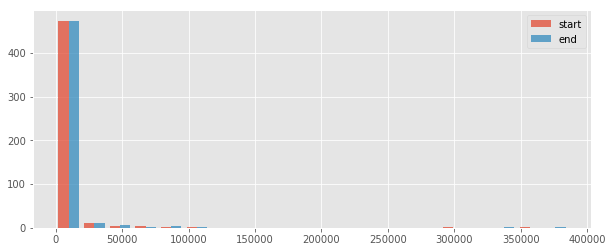

In [81]:
fig, ax = plt.subplots(1, 1, figsize=[10,4])

ax.hist([np.sort(wealth_start), np.sort(wealth_end)], 20, alpha=0.75, label=['start', 'end'])
#ax.hist(, 20, facecolor='red', alpha=0.50)
plt.legend(loc='upper right')

In [13]:
wealth_gini_over_time = []
palma_over_time = []
twentytwenty_over_time = []
for t in range(burn_in_period + start_dates[bubble_n], burn_in_period + end_dates[bubble_n]):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    stocks = np.array([x.var.stocks[t] for x in trdrs[0]])
    wealth = money + (stocks * orbs[0].tick_close_price[t])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palma_over_time.append(share_top_10 / share_bottom_40)
    
    share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
    share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
    twentytwenty_over_time.append(share_top_20 / share_bottom_20)
    
    wealth_gini_over_time.append(gini(wealth))

NameError: name 'start_dates' is not defined

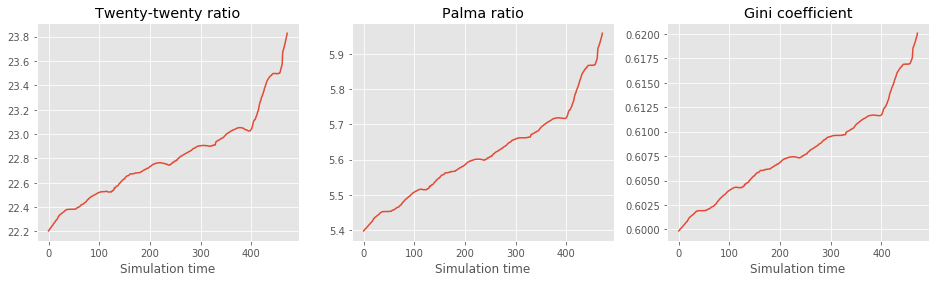

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.plot(range(len(twentytwenty_over_time)), twentytwenty_over_time)
ax2.plot(range(len(palma_over_time)), palma_over_time)
ax3.plot(range(len(wealth_gini_over_time)), wealth_gini_over_time)

ax1.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax3.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation time')

fig.savefig('gini_palma_twenty_evolution_bubble.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Redistributional dynamics

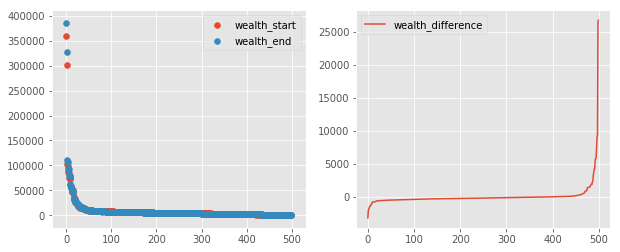

In [84]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[10,4])

#ax.bar([wealth_start, wealth_end], 20, alpha=0.75, label=['start', 'end'])
#ax.bar([x for x in range(len(wealth_start))], wealth_start)
ax.scatter(range(len(wealth_start)), wealth_start, label='wealth_start')
ax.scatter(range(len(wealth_end)), wealth_end, label='wealth_end')
#ax.hist(, 20, facecolor='red', alpha=0.50)
ax1.plot(range(len(wealth_start)), np.sort(wealth_end - wealth_start), label='wealth_difference')

ax.legend(loc='best')
ax1.legend(loc='best')

# Typical model dynamics

## Expectation dynamics

In [65]:
fundamentalist_component_at_t = 0
for x in trdrs[0]:
    fundamentalist_component_at_t += np.array(x.var.weight_fundamentalist)

In [66]:
fundamentalist_components = [np.array(x.var.weight_fundamentalist) for x in trdrs[0]]
chartist_components = [np.array(x.var.weight_chartist) for x in trdrs[0]]
random_components = [np.array(x.var.weight_random) for x in trdrs[0]]

In [67]:
fundamentalist_sentiment = sum(fundamentalist_components)
chartist_sentiment = sum(chartist_components)
random_sentiment = sum(random_components)
total_sentiment = fundamentalist_sentiment + chartist_sentiment + random_sentiment

In [68]:
def market_sentiment_in_round(order_book, t):
    return sum(np.array(order_book.sentiment_history[t]) / len(order_book.sentiment_history[t]))

In [69]:
market_sentiment_in_round(orbs[0], -1)

array([0.90959872, 0.03250654, 0.05789474])

In [70]:
f_sent_in_round = []
c_sent_in_round = []
r_sent_in_round = []
for t in range(params['ticks']):
    f_sent_in_round.append(market_sentiment_in_round(orbs[0], t)[0])
    c_sent_in_round.append(market_sentiment_in_round(orbs[0], t)[1])
    r_sent_in_round.append(market_sentiment_in_round(orbs[0], t)[2])

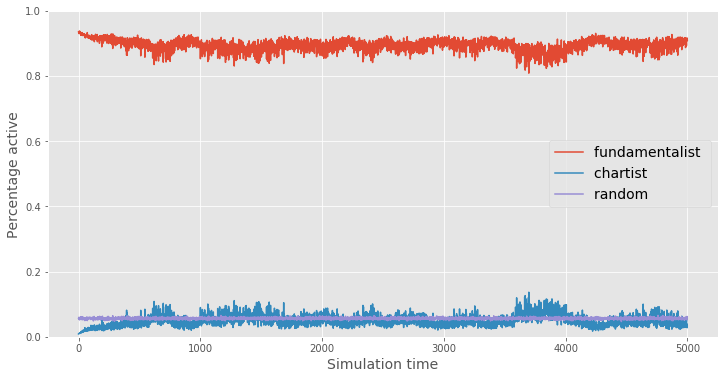

In [71]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,6))

# ax1.plot(range(len(fundamentalist_sentiment)), fundamentalist_sentiment / total_sentiment, label='fundamentalist sentiment')
# ax1.plot(range(len(chartist_sentiment)), chartist_sentiment / total_sentiment, label='chartist sentiment')
# ax1.plot(range(len(random_sentiment)), random_sentiment / total_sentiment, label='random sentiment')
# ax1.set_ylim(0, 1)



ax1.plot(range(len(f_sent_in_round)), f_sent_in_round, label='fundamentalist ')
ax1.plot(range(len(c_sent_in_round)), c_sent_in_round, label='chartist ')
ax1.plot(range(len(r_sent_in_round)), r_sent_in_round, label='random ')
ax1.set_ylim(0, 1)
ax1.set_xlabel('Simulation time', fontsize='14')

#ax1.set_title('Active sentiment')
#ax2.set_title('Active sentiment')
ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('Percentage active', fontsize='14')
ax1.legend(loc='best', fontsize='14')

fig.savefig('market_sentiment.png')

## Empirical performance

In [37]:
orbs = len(mc_fundamentals[0])
r0 = 0.01 + 1.8/np.sqrt(orbs)
swindow0 = int(math.floor(r0*orbs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 99

first_order_autocors = []
mean_abs_autocor = []
kurtoses = []
perc_bubble_occur = []
av_lenghts_of_bubbles = []
stdev_lenghts_bubbles = []
skews_lenghts_bubbles = []
kurt_lengths_bubbles = []


for idx, col in enumerate(mc_returns):
    first_order_autocors.append(autocorrelation_returns(mc_returns[col][1:], 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(mc_returns[col][1:], 25))
    kurtoses.append(mc_returns[col][2:].kurtosis())
    # calc bubble stats
    pds = pd.Series(mc_prices[idx][:-1] / mc_fundamentals[idx])
    
    obs = len(pds)
    bsadfs = PSY(pds, swindow0, IC, adflag)
    quantilesBsadf = cvPSYwmboot(pds, swindow0, IC, adflag, Tb, nboot)
    monitorDates = pds.iloc[swindow0-1:obs].index
    quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
    ind95 =(bsadfs.T[0] > quantile95[1, ])
    periods = monitorDates[ind95]
    
    bubbly_dates = find_sequences_ints(periods, monitorDates)
    
    perc_bubble_occur.append(len(periods) / float(len(monitorDates)))
    lenghts_of_bubbles = []
    for row in range(len(bubbly_dates)):
        lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)
    av_lenghts_of_bubbles.append(np.mean(lenghts_of_bubbles))
    stdev_lenghts_bubbles.append(np.std(lenghts_of_bubbles))
    skews_lenghts_bubbles.append(pd.Series(lenghts_of_bubbles).skew())
    kurt_lengths_bubbles.append((pd.Series(lenghts_of_bubbles).kurtosis()))

stylized_facts_sim = np.array([first_order_autocors,
                            mean_abs_autocor,
                            kurtoses,
                            perc_bubble_occur,
                            av_lenghts_of_bubbles,
                            stdev_lenghts_bubbles,
                            skews_lenghts_bubbles,
                            kurt_lengths_bubbles
                           ])

In [38]:
for st in stylized_facts_sim:
    print(st)

[0.07322563 0.01721955]
[0.09921148 0.11288301]
[ 15.33863112 198.31336225]
[0.11413043 0.05253623]
[10.5         3.22222222]
[9.84462628 5.26577583]
[1.3863729  2.91448082]
[1.97435399 8.59706003]


### The distribution of Wealth
Wealth is measured as trader money + trader stock * price 

In [72]:
money = np.array([x.var.money[-1] for x in trdrs[0]])
stocks = np.array([x.var.stocks[-1] for x in trdrs[0]])
wealth = money + (stocks * mc_prices[0].iloc[-1])
#n, bins, patches = plt.hist(wealth, 50, density=True, alpha=0.75)

In [73]:
start_money = np.array([x.var.money[0] for x in trdrs[0]])
start_stocks = np.array([x.var.stocks[0] for x in trdrs[0]])
start_wealth = start_money + (start_stocks * mc_prices[0].iloc[0])

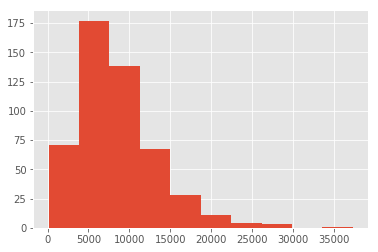

In [74]:
pd.Series(np.sort(wealth)).hist()

### Descriptives

In [75]:
pd.Series(wealth).describe()

count      500.000000
mean      8440.833029
std       4817.182888
min        122.681685
25%       5029.474285
50%       7628.928823
75%      10812.013010
max      37296.359745
dtype: float64

Skewness and Kurtosis

In [76]:
print('Start of simulation skewness is ', pd.Series(start_wealth).skew())
print('End of simulation skewness is ', pd.Series(wealth).skew())
print('-----')
print('Start of simulation Kurtosis is ', pd.Series(start_wealth).kurtosis())
print('End of simulation Kurtosis is ', pd.Series(wealth).kurtosis())

Start of simulation skewness is  -0.0689625700284712
End of simulation skewness is  1.3772089854347922
-----
Start of simulation Kurtosis is  -0.6316686211634419
End of simulation Kurtosis is  3.5988937168716206


### Ratios

#### Palma ratio
It is the ratio of national income shares of the top 10 per cent of
households to the bottom 40 per cent.

In [77]:
share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
print('Share top 10 is ', share_top_10)
share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
print('Share bottom 40 is ', share_bottom_40)

Share top 10 is  0.22181338207233312
Share bottom 40 is  0.20480252933864448


In [78]:
palma = share_top_10 / share_bottom_40
print('Palma ratio is ', palma)

Palma ratio is  1.0830597785516647


### 20/20 ratio
Compares the ratio of the average income of the richest 20
per cent of the population to the average income of the poorest
20 per cent of the population.

In [79]:
share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
print('Average wealth top 20 is ', share_top_20)
share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
print('Average wealth bottom 20 is ', share_bottom_20)
twenty_twenty = share_top_20 / share_bottom_20
print('20/20 ratio is ', twenty_twenty)

Average wealth top 20 is  15804.986930882274
Average wealth bottom 20 is  3081.0965714024937
20/20 ratio is  5.129662951034331


### Cumulative distribution

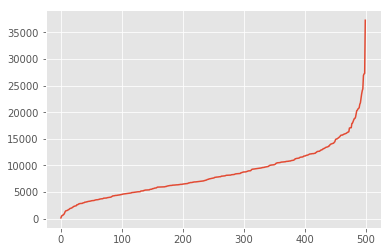

In [80]:
pd.Series(np.sort(wealth)).plot()

### Lorenz curve and Gini coefficient 

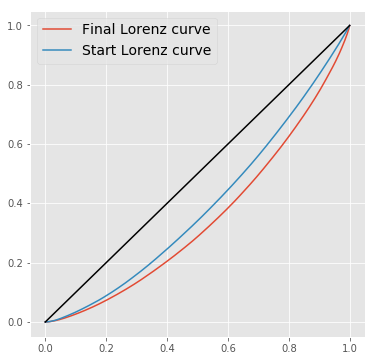

In [81]:
end_wealth = np.sort(wealth)
lorenz_end = end_wealth.cumsum() / end_wealth.sum()
lorenz_end = np.insert(lorenz_end, 0, 0)

st_wealth = np.sort(start_wealth)
lorenz_st = st_wealth.cumsum() / st_wealth.sum()
lorenz_st = np.insert(lorenz_st, 0, 0)

fig, ax = plt.subplots(figsize=[6,6])
# scatter plot of Lorenz curve
ax.plot(np.arange(lorenz_end.size)/float((lorenz_end.size-1)), lorenz_end, label='Final Lorenz curve')

ax.plot(np.arange(lorenz_st.size)/float((lorenz_st.size-1)), lorenz_st, label='Start Lorenz curve')
# line plot of equality
ax.plot([0,1], [0,1], color='k')
ax.legend(loc='best', fontsize='14')

In [82]:
wealth_gini_over_time = []
palma_over_time = []
twentytwenty_over_time = []
for t in range(params['ticks']):
    #print(t)
    money = np.array([x.var.money[t] for x in trdrs[0]])
    stocks = np.array([x.var.stocks[t] for x in trdrs[0]])
    wealth = money + (stocks * orbs[0].tick_close_price[t])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palma_over_time.append(share_top_10 / share_bottom_40)
    
    share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
    share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
    twentytwenty_over_time.append(share_top_20 / share_bottom_20)
    
    wealth_gini_over_time.append(gini(wealth))

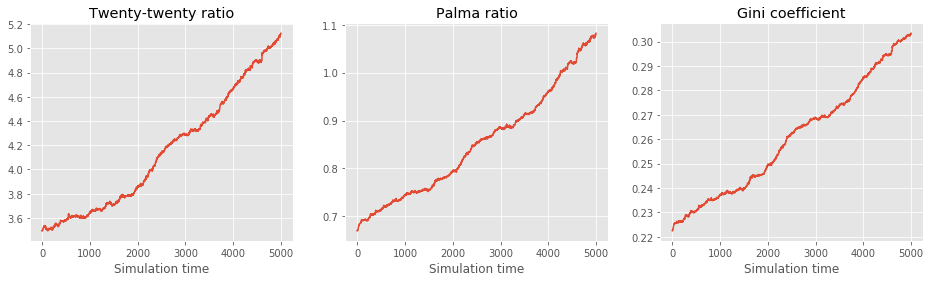

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.plot(range(len(twentytwenty_over_time)), twentytwenty_over_time)
ax2.plot(range(len(palma_over_time)), palma_over_time)
ax3.plot(range(len(wealth_gini_over_time)), wealth_gini_over_time)

ax1.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax3.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation time')

fig.savefig('gini_palma_twenty_evolution.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

### Characteristics of agents on the distribution
Questions:
1. What characteristics correlate with wealth at the end of the simulation?
2. what about the bottom (least wealthy) agents?
3. what about the top? (most wealthy) agents?

Possible characteristics are: 
- risk aversion
- starting wealth
- strenght of the chartist vs. fundamentalist component
- strenght of the random component
- horizon
- learning ability
- spread

In [199]:
# TODO make this deal well with multiple seeds!
# gather info on all of these characteristics in DF
for s in range(len(trdrs)):
    risk_aversions = np.array([x.par.risk_aversion for x in trdrs[s]])
    chartist_v_funds = [np.mean(np.array(x.var.weight_chartist) / np.array(x.var.weight_fundamentalist)) for x in trdrs[s]]
    random_components = [np.mean(np.array(x.var.weight_random) * x.var.forecast_adjust) for x in trdrs[s]]
    horizons = np.array([x.par.horizon for x in trdrs[s]])
    learning_abilities = np.array([x.par.learning_ability for x in trdrs[s]])
    spreads = np.array([x.par.spread for x in trdrs[s]])

In [200]:
characteristics_data = pd.DataFrame({'risk_aversion': risk_aversions, 'chartists_v_funds': chartist_v_funds, 
             'random_components': random_components, 'horizons': horizons, 'learning': learning_abilities,
             'spreads': spreads, 'start_wealth': start_wealth, 'end_wealth': end_wealth})

In [201]:
characteristics_data.head()

,risk_aversion,chartists_v_funds,random_components,horizons,learning,spreads,start_wealth,end_wealth
0,12.278392,0.804616,0.030877,44,0.304623,0.004027,16373.136046,255.159651
1,11.595645,0.777267,0.015406,111,0.725448,0.003047,16160.804699,446.341813
2,7.272851,1.187889,0.018676,75,0.111143,0.002037,15601.285331,593.478142
3,6.909722,0.773299,0.031895,29,0.733647,0.002705,15167.396389,687.679584
4,7.443744,0.339259,0.006104,31,0.041269,0.000032,16157.453153,761.362751


In [202]:
characteristics_data.corrwith(characteristics_data['end_wealth'])

risk_aversion       -0.047473
chartists_v_funds   -0.044808
random_components    0.019582
horizons             0.057720
learning             0.012185
spreads             -0.065547
start_wealth        -0.989274
end_wealth           1.000000
dtype: float64

# Experiments 

## Experiment 1: Are bubbles associated with more redistribution?

In [92]:
params

{'ticks': 2516,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'w_random': 1.0,
 'init_stocks': 50,
 'trader_sample_size': 29,
 'std_noise': 0.24956951,
 'w_fundamentalists': 64.60170069,
 'w_momentum': 4.58849333,
 'base_risk_aversion': 8.36445485,
 'horizon': 185,
 'fundamentalist_horizon_multiplier': 0.99531144,
 'trades_per_tick': 2,
 'mutation_probability': 0.80038573,
 'average_learning_ability': 0.93207344}

In [57]:
params['ticks'] = 1235

In [54]:
total_strategy_weight = params['w_fundamentalists'] + params['w_momentum']

In [55]:
# move from one to the other list from 5 to 100 percent
weights_experiment = [np.array([x / 100.0, (100-x) / 100.0]) for x in range(0, 105, 5)]

In [60]:
trdrs_exp1 = []
orbs_exp1 = []
for exp, weight in enumerate(weights_experiment):
    strategy_weights = weight * total_strategy_weight
    params['w_fundamentalists'] = strategy_weights[0]
    params['w_momentum'] = strategy_weights[1]
    traders, orderbook = init_objects_distr(params, 0)
    traders, orderbook = pb_distr_model(traders, orderbook, params, 0)
    trdrs_exp1.append(traders)
    orbs_exp1.append(orderbook)

Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0


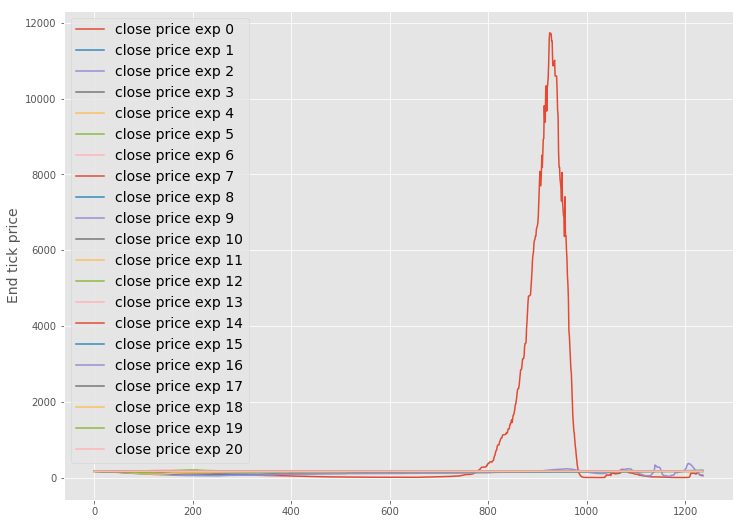

In [70]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

for exp in range(len(weights_experiment)):
    ax1.plot(range(len(orbs_exp1[exp].tick_close_price)), orbs_exp1[exp].tick_close_price, label='close price exp {}'.format(exp))

ax1.set_ylabel('End tick price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

Calculate gini, palma & twenty twenty for different simulations

In [62]:
wealth_gini_exp1 = []
palma_exp1 = []
twentytwenty_exp1 = []
for exp in range(len(weights_experiment)):
    #money at time t-1, 
    money = np.array([x.var.money[-1] for x in trdrs_exp1[exp]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs_exp1[exp]])
    wealth = money + (stocks * orbs_exp1[exp].tick_close_price[-1])
                      
    wealth_gini_exp1.append(gini(wealth))
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palma_exp1.append(share_top_10 / share_bottom_40)
    
    share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
    share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
    twentytwenty_exp1.append(share_top_20 / share_bottom_20)

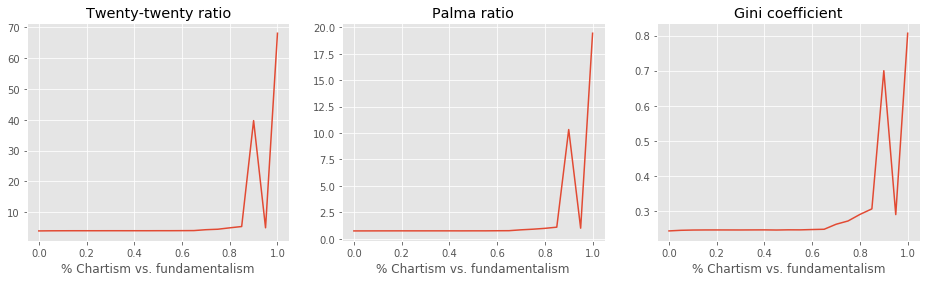

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.plot([w[0] for w in weights_experiment], twentytwenty_exp1[::-1])
ax2.plot([w[0] for w in weights_experiment], palma_exp1[::-1])
ax3.plot([w[0] for w in weights_experiment], wealth_gini_exp1[::-1])

ax1.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax3.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('% Chartism vs. fundamentalism')

fig.savefig('more_chartism_creates_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [116]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

Explore if deviations from fundamental predict inequality. Calculate the Euclidean distance between the price and the fundamental value as: $\sum_{n=1}^{N}(f_n - p_n)$. 

In [111]:
# calc deviation from fundamentals
eucl_dev_from_fundamental_exp = []
for exp in range(len(weights_experiment)):
    eucl_dev_from_fundamental_exp.append(np.linalg.norm(np.array([orbs_exp1[exp].fundamental]) - np.array([orbs_exp1[exp].tick_close_price[1:]])))

Regressing wealth on the deviation from fundamental (proxy for boom and bust cycles) reveals that there is a strong, highly significant relationship between the two. Market inefficiency predicts higher inequality.

In [136]:
X = pd.Series(np.log(eucl_dev_from_fundamental_exp[::-1])) #TODO find out if I can take log here. 
X = sm.add_constant(X)
y = np.log(wealth_gini_exp1[::-1])

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     40.50
Date:                Fri, 25 Jan 2019   Prob (F-statistic):           4.19e-06
Time:                        16:43:21   Log-Likelihood:                 5.7875
No. Observations:                  21   AIC:                            -7.575
Df Residuals:                      19   BIC:                            -5.486
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8214      0.097    -18.760      0.000      -2.025      -1.618
0              0.1193      0.019      6.364      0.000       0.080       0.159
==============================================================================
Omnibus:                        6.222   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                3.831
Skew:                           0.857   Prob(JB):                        0.147
Kurtosis:                       4.201   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
summary_col(model, stars=True, float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared)})

,y
const,-1.82***
,(0.10)
0,0.12***
,(0.02)
N,21
R2,0.68


In [90]:
# calc kurtosis
kurtosis_per_exp = []
for exp in range(len(weights_experiment)):
    kurtosis_per_exp.append(pd.Series(orbs_exp1[exp].tick_close_price).pct_change().kurtosis())

Explore if excess kurtosis predicts inequality

In [104]:
X = pd.Series(kurtosis_per_exp[::-1])
X = sm.add_constant(X)
y = wealth_gini_exp1[::-1]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.509
Date:                Fri, 25 Jan 2019   Prob (F-statistic):              0.130
Time:                        13:41:10   Log-Likelihood:                 11.604
No. Observations:                  21   AIC:                            -19.21
Df Residuals:                      19   BIC:                            -17.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2607      0.042      6.277      0.000       0.174       0.348
0              0.0007      0.000      1.584      0.130      -0.000       0.002
==============================================================================
Omnibus:                       23.362   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.980
Skew:                           2.172   Prob(JB):                     1.87e-07
Kurtosis:                       7.067   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Correlation curves and coefficients

### Concentration curves

The concentration curve plots the cumulative percentage of the a variable of interest (y-axis) against the cumulative percentage of the sample, ranked by wealtht, beginning with poorest agents , and ending with the richest agents (x-axis) (source: World Bank).

The items of interest are: 
1. risk aversion,
2. relative weight of chartism
3. relative weight of fundamentalism
4. relative weight of chartism vs. fundamentalism
5. horizon

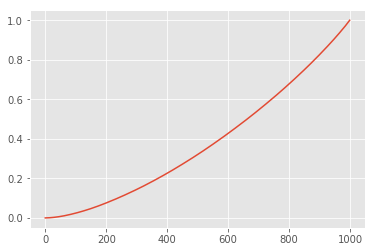

In [60]:
pd.Series(np.cumsum(np.sort(wealth) / sum(wealth))).plot()

In [62]:
# TODO somewhere here, I should modify the vars to take into account multiple seeds
risk_aversion = np.array([x.par.risk_aversion for x in trdrs[0]])
weight_chart = np.array([x.var.weight_chartist * x.var.forecast_adjust for x in trdrs[0]])
weight_fund = np.array([x.var.weight_fundamentalist * x.var.forecast_adjust for x in trdrs[0]])
horizon = np.array([float(x.par.horizon) for x in trdrs[0]])

c_curve_data = pd.DataFrame({'wealth': (wealth / sum(wealth)), 
                             'risk_aversion': (risk_aversion / sum(risk_aversion)), 
                             'weigth_chart': (weight_chart / sum(weight_chart)), 
                             'weight_fundamental': (weight_fund / sum(weight_fund)), 
                             'horizon': (horizon / sum(horizon))})

c_curve_data = c_curve_data.sort_values('wealth')
# need rank based on fractional rank

TypeError: can't multiply sequence by non-int of type 'float'

If a curve is above the equality line, this indicates that agents which have a large amount of that variable are more likely to be poor?  

NameError: name 'c_curve_data' is not defined

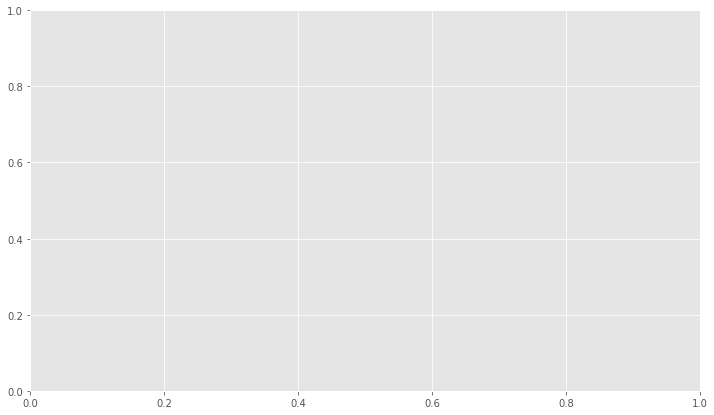

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['risk_aversion']), label='x = risk aversion')
ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['weigth_chart']), label='x = chartist weight')
ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['weight_fundamental']), label='x = fundamentalist weight')
ax.plot(np.cumsum(c_curve_data['wealth']), np.cumsum(c_curve_data['horizon']), label='x = horizon') # this doesn't really work yet 
ax.plot([0,1], [0,1], 'k--', label='line of equality')

ax.set_ylabel('Cumulative percentage x', fontsize=14)
ax.set_xlabel('Cumulative percentage of Wealth', fontsize=14)
ax.legend(fontsize=14, loc='best')

fig.savefig('concentration_curves.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

The concentration index is defined as twice the area between the concentration curve and the line of equality (the 45-degree line) (source: WB). The convention is that the index takes a negative value when the curve lies above the line of equality, indicating disproportionate concentration of the variable of interest among the poor, and a positive value when it lies below the line of equality. **Therefore, a negative value of the index shows that more poor agents have that property and vice versa.** 

It can be calculated as follows:

$C = \frac{2}{\bar{x}} cov(x, r)$

where $x$ is the variable of interest, $\bar{x}$ it's average, and r its fractional rank in the wealth distribution. 

In [30]:
c_index_data = pd.DataFrame({'wealth': wealth, 
                             'risk_aversion': risk_aversion, 
                             'weigth_chart': weight_chart, 
                             'weight_fundamental': weight_fund, 
                             'horizon': horizon})

c_index_data['frac_rank'] = scipy.stats.rankdata(c_index_data['wealth'], method='average') / len(c_index_data['wealth'])

In [31]:
c_index_data.cov()

,wealth,risk_aversion,weigth_chart,weight_fundamental,horizon,frac_rank
wealth,3.408979e+08,-874.379415,-62.142105,48.749670,-18475.510548,1426.644892
risk_aversion,-8.743794e+02,6.964979,-0.006175,0.004802,-0.091411,0.216232
weigth_chart,-6.214210e+01,-0.006175,0.002665,-0.002090,0.004900,-0.003980
weight_fundamental,4.874967e+01,0.004802,-0.002090,0.001646,-0.004367,0.003126
horizon,-1.847551e+04,-0.091411,0.004900,-0.004367,21.503014,-0.176718
frac_rank,1.426645e+03,0.216232,-0.003980,0.003126,-0.176718,0.083417


In [32]:
def concentr_index(var_name):
    return (2 / c_index_data[var_name].mean()) * c_index_data.cov().loc[var_name]['frac_rank']

In [33]:
# TODO check if this is correct!
concentration_indexes = {key: concentr_index(key) for key in c_curve_data.columns}
pd.Series(concentration_indexes)

wealth                0.892049
risk_aversion         0.033011
weigth_chart         -0.010218
weight_fundamental    0.035380
horizon              -0.019837
dtype: float64

Doorslaer (2004) have shown that multiplying the value of the concentration index by 75 gives the percentage of the health variable that would need to be (linearly) redistributed from the richer half to the poorer half of the population (in the case that health inequality favors the rich) to arrive at a distribution with an index value of zero.